<a href="https://colab.research.google.com/github/eeshashetty/captionary-api/blob/main/blip_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!nvidia-smi

Thu Oct 12 19:57:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |  10647MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [148]:
%%bash
pip install transformers
pip install datasets
pip install coremltools
pip install thop

Process is terminated.


In [1]:
import torch
import gc
from tqdm.auto import tqdm
from nltk.translate.bleu_score import sentence_bleu
import os
from torchsummary import summary
import coremltools as ct
from datasets import load_dataset
import torchvision
# import wandb
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [2]:
raw_data = load_dataset("ThraggBilly/flickr30k_dataset")

In [3]:
data = raw_data['train'].train_test_split(test_size=0.3)
train_data = data['train']
test_data = data['test']

In [4]:
# train = load_dataset("eeshclusive/captionary-dataset", split = "train")
# test = load_dataset("eeshclusive/captionary-dataset", split = "test")

In [5]:
# size 224 300 348
config = {
    'batch_size': 8,
    'lr': 5e-5,
    'epochs': 5,
    "size" : 224,
    "type" : "base",
    "trans" : "resize", # or crop
}

In [6]:
custom_size = {"height": config["size"], "width":  config["size"]}

In [7]:
from transformers import AutoProcessor, BlipForConditionalGeneration
model, processor, transforms = None, None, None
if config["type"] == "base":
  processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base", size = custom_size)
  model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
else:
  processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-large", size = custom_size)
  model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")
if config["trans"] == "crop":
  transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop(config["size"]),
  ])
else:
  transforms = None
print(transforms)

In [8]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor, transforms=None):
        self.dataset = dataset
        self.processor = processor
        self.transforms = transforms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        if self.transforms:
          img = self.transforms(item["image"])
        else:
          img = item["image"]
        encoding = self.processor(images=img, text=item["text"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [9]:
import itertools

train_dataset = ImageCaptioningDataset(train_data, processor, transforms=transforms)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=config['batch_size'])
train_dataloader = itertools.islice(train_dataloader, 500)

In [11]:
test_dataset = ImageCaptioningDataset(test_data, processor, transforms=transforms)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config['batch_size'])
test_dataloader = itertools.islice(test_dataloader, 500)


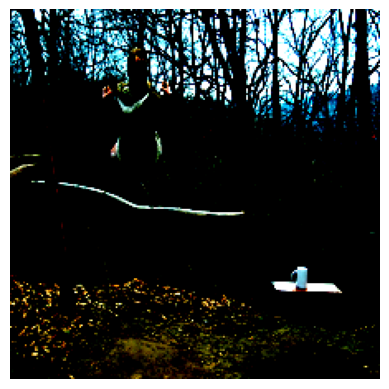

dict_keys(['pixel_values', 'input_ids', 'attention_mask'])
torch.Size([8, 3, 224, 224])
torch.Size([8, 512])
torch.Size([8, 512])


In [12]:
import numpy as np
import matplotlib.pyplot as plt
for idx, batch in enumerate(train_dataloader):
  pixel_value = batch['pixel_values'][0]
  image = np.transpose(pixel_value, (1, 2, 0))
  plt.imshow(image)
  plt.axis('off')
  plt.show()
  print(batch.keys())
  print(batch['pixel_values'].shape)
  print(batch['input_ids'].shape)
  print(batch['attention_mask'].shape)
  break

In [13]:
torch.cuda.empty_cache()
gc.collect()

2377

In [14]:
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])

model.to(device)



BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [15]:
from thop import profile
input_ids = index_tensor = torch.randint(0, 10, (1, 512), dtype=torch.long).to(device)
pixel_values = torch.randn(1, 3, config["size"], config["size"]).to(device)

flops, params = profile(model, inputs=(pixel_values,input_ids))
print(f"Total FLOPs: {flops} GFLOPs")

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")



[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
Total FLOPs: 82750138368.0 GFLOPs
Total number of parameters: 247414076


In [16]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
# wandb.save('model_arch.txt')

In [17]:
def bleu_score(cap, preds, processor):
    """

    cap: ref
    preds: candidate
    """

    # Calculate BLEU score
    bleu = 0

    # Decode the caption
    decoded_preds = processor.tokenizer.batch_decode(preds, skip_special_tokens=False)
    decoded_cap = processor.tokenizer.batch_decode(cap, skip_special_tokens=True)

    for batch in range(preds.shape[0]):

        decoded_pred = decoded_preds[batch].split(' ')

        for i in range(len(decoded_pred)):
            if decoded_pred[i] == '[SEP]':
                break

        # decoded_preds_batch = processor.tokenizer.decode(.tolist(), skip_special_tokens=True)
        # decoded_cap_batch = processor.tokenizer.decode(cap[batch].tolist(), skip_special_tokens=True)

        # decoded_preds.append(decoded_preds_batch)
        # # decoded_preds.append(' '.join(decoded_preds_batch))
        # decoded_cap.append(decoded_cap_batch)
        # # decoded_cap.append(' '.join(decoded_cap_batch))

        # bleu_score += sentence_bleu(decoded_cap_batch, decoded_preds_batch)
        # print('decoded_preds', decoded_pred[:i])
        # print('decoded_preds[batch]', [decoded_pred[:i]])
        # print('decoded_cap', decoded_cap[batch])
        # print('decoded_cap[batch]', decoded_cap[batch].split(' '))
        bleu_batch = sentence_bleu([decoded_cap[batch].split(' ')], decoded_pred[:i], weights=[0.6, 0.4, 0, 0])
        bleu += bleu_batch

        # print(f'BLEU: {bleu_batch}')

    bleu /= preds.shape[0]

    return bleu, decoded_preds, decoded_cap

In [18]:
def train(model, dataloader, optimizer):
  model.train()
  tloss, tacc, tbleu = 0, 0, 0 # Monitoring loss and accuracy

  predictions = []
  targets = []

  batch_bar   = tqdm(total=500, dynamic_ncols=True, leave=False, position=0, desc='Train')

  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
    attention_mask = batch.pop("attention_mask").to(device)

    ### Initialize Gradients
    optimizer.zero_grad()

    with torch.autocast(device_type='cuda', dtype=torch.float16):
      ### Forward Propagation
      outputs  = model(input_ids=input_ids,
                  pixel_values=pixel_values,
                  labels=input_ids, attention_mask=attention_mask)

      preds = outputs.logits.argmax(-1)

      ### Loss Calculation
      loss    = outputs.loss


    ### Backward Propagation
    scaler.scale(loss).backward()

    ### Gradient Descent
    scaler.step(optimizer)

    ### BLEU score
    bleu, decoded_preds, decoded_cap = bleu_score(input_ids, preds, processor)

    predictions.extend(decoded_preds)
    targets.extend(decoded_cap)

    tbleu += bleu

    scaler.update()

    tloss   += loss.item()

    batch_bar.set_postfix(
      loss="{:.04f}".format(float(tloss / (idx + 1))),
      bleu="{:.04f}".format(float(tbleu / (idx + 1)))
    )

    batch_bar.update()

    ### Release memory
    del input_ids, pixel_values, outputs
    torch.cuda.empty_cache()

  batch_bar.close()
  tloss   /= 500
  tbleu   /= 500

  return tloss, tbleu, predictions, targets

In [19]:
def eval(model, dataloader):
  model.eval() # set model in evaluation mode
  vloss, vacc, vbleu = 0, 0, 0 # Monitoring loss and accuracy
  batch_bar   = tqdm(total=500, dynamic_ncols=True, position=0, leave=False, desc='Val')

  predictions = []
  targets = []

  for idx, batch in enumerate(dataloader):

    ### Move data to device (ideally GPU)
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)
    attention_mask = batch.pop("attention_mask").to(device)

    # makes sure that there are no gradients computed as we are not training the model now
    with torch.inference_mode():
      ### Forward Propagation
      outputs  = model(input_ids=input_ids,
                  pixel_values=pixel_values,
                  labels=input_ids, attention_mask=attention_mask)

      preds = outputs.logits.argmax(-1)

      ### Loss Calculation
      loss    = outputs.loss

    vloss   += loss.item()

    batch_bar.set_postfix(
      loss="{:.04f}".format(float(vloss / (idx + 1))),
      bleu="{:.04f}".format(float(vbleu / (idx + 1)))
    )

    batch_bar.update()

    ### BLEU score
    bleu, decoded_preds, decoded_cap = bleu_score(input_ids, preds, processor)
    predictions.extend(decoded_preds)
    targets.extend(decoded_cap)
    vbleu += bleu

    ### Release memory
    del input_ids, pixel_values, outputs
    torch.cuda.empty_cache()

  batch_bar.close()
  vloss   /= 500
  vbleu   /= 500

  return vloss, vbleu, predictions, targets

In [21]:
# !mkdir outputs

In [20]:
#torch.cuda.empty_cache()
gc.collect()

2155

In [ ]:
 # Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()

best_val_loss = -1

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    train_loss, train_bleu, train_preds, train_targets  = train(model, train_dataloader, optimizer)
    val_loss, val_bleu, val_preds, val_targets          = eval(model, test_dataloader)

    print("\tTrain Loss {:.04f}".format(train_loss))
    print("\tVal Loss {:.04f}".format(val_loss))
    print("\tVal bleu {:.04f}".format(val_bleu))

    # wandb.log({
    #     "Train/Loss": train_loss,
    #     "Train/BLEU": train_bleu,
    #     "Val/Loss": val_loss,
    #     "Val/BLEU": val_bleu,
    #     "Train/Predictions": wandb.Table(data=train_preds, columns=["Predictions"]),
    #     "Train/Targets": wandb.Table(data=train_targets, columns=["Targets"]),
    #     "Val/Predictions": wandb.Table(data=val_preds, columns=["Predictions"]),
    #     "Val/Targets": wandb.Table(data=val_targets, columns=["Targets"])
    # })

    if val_loss < best_val_loss or best_val_loss == -1:
            best_val_loss = val_loss
            print(f"\nLowest validation loss: {best_val_loss:}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(model.state_dict(), f"outputs/model_{epoch+1}_{val_loss}.pth")



Epoch 1/8


Train:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

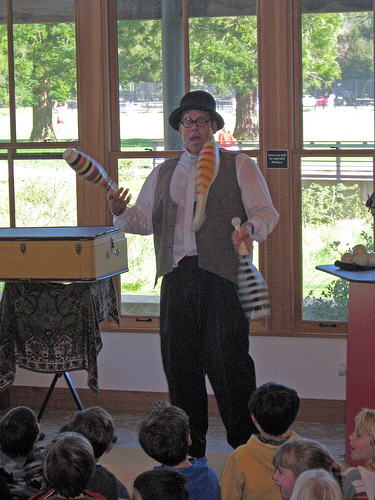

In [30]:
# load image
example = train_data[0]
image = example["image"]
image

In [ ]:
from PIL import Image
import requests

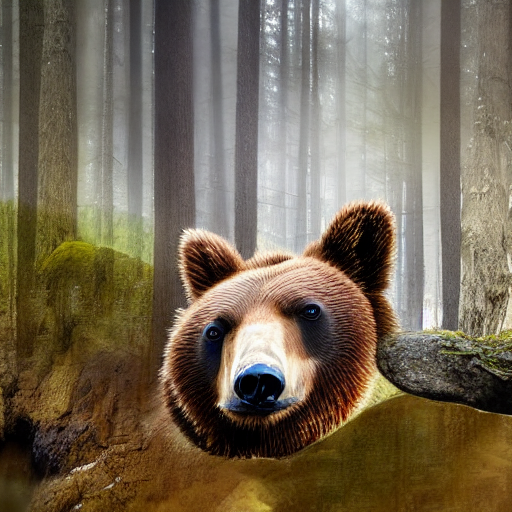

In [ ]:
url_pic = "https://replicate.delivery/pbxt/NFSsdG1sVxqUOJrduzNnh8jmON5hKcZBjHYze1qTXNe52siQA/output_1.png"
image = Image.open(requests.get(url_pic, stream=True).raw)
image

In [ ]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)


a woman and a child are standing in a forest


In [ ]:
inputs = processor(text=["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")
text_features = model.get_text_features(**inputs)

AttributeError: ignored

In [ ]:
# !pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import huggingface_hub
huggingface_hub.login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
MODEL_NAME = config["type"]+"_"+str(config["size"])+"_"+config["trans"]
print(MODEL_NAME)


Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/eeshclusive/captionary-BLIP/commit/22e330c768cbbb47202ff54ba37616bbe2157f22', commit_message='Upload BlipForConditionalGeneration', commit_description='', oid='22e330c768cbbb47202ff54ba37616bbe2157f22', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model.push_to_hub(f"living-on-edge/{MODEL_NAME}")